# **AA1 Project** 

## Modeling delays in the air

In order to predict whether a flight is likely to be delayed or not, create a ML model that will make predictions with that aim. 

First of all. Let's observe our data set and some first insights. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import seaborn as sns

## Reading the data

For this project, we will be working with the *flights* dataset downloaded from *Kaggle*. However, there is some information from the airports that appear in the dataset that is stored in the *airports* file so we will also need it.

In [2]:
airports = pd.read_csv('airports.csv')

Due to the amount of data in the *flights* file, we will be using only a random subset of it so we are able to get good results while avoid slowing the execution of the project to unacceptable and unfeasible levels. We will be working with 0.1% of the original datai, i.e.: XXXXX rows.

In [3]:
flights = pd.read_csv('flights.csv')
flights = flights.sample(frac=0.001, random_state=42)

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_9237/2534244135.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


As we can se with the `describe` method, we can observe the range where each feature takes values at more or less. It is also interesting to observe the histograms of the different columns to see how each feature is distributed more or less, to get an intuition of our data. 

In [4]:
flights.describe()
airports.describe()

,LATITUDE,LONGITUDE
count,319.000000,319.000000
mean,38.981244,-98.378964
std,8.616736,21.523492
min,13.483450,-176.646030
25%,33.652040,-110.839385
50%,39.297610,-93.403070
75%,43.154675,-82.722995
max,71.285450,-64.798560


array([[<AxesSubplot: title={'center': 'YEAR'}>,
        <AxesSubplot: title={'center': 'MONTH'}>,
        <AxesSubplot: title={'center': 'DAY'}>,
        <AxesSubplot: title={'center': 'DAY_OF_WEEK'}>,
        <AxesSubplot: title={'center': 'FLIGHT_NUMBER'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_DEPARTURE'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_TIME'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>,
        <AxesSubplot: title={'center': 'WHEELS_OFF'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'ELAPSED_TIME'}>,
        <AxesSubplot: title={'center': 'AIR_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>,
        <AxesSubplot: title={'center': 'WHEELS_ON'}>],
       [<AxesSubplot: title={'center': 'TAXI_IN'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_ARRIVAL'}>,
        <AxesSubplot: title={'center': 'ARRIVAL_TIME'}>

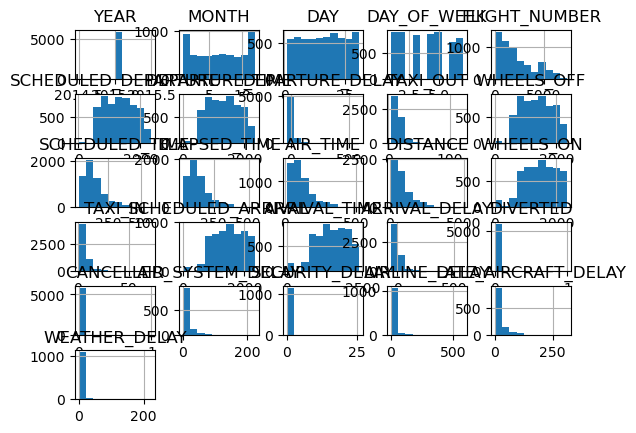

In [5]:
flights.hist()

Based on the results of the histograms, we can appreciate that some of the variables in our dataset present variables where the data appears to be quite concentrated and this could be explained by the presence of large outliers. Some other variables seem to be more uniformally distributed. However, the nature of the distribution that describes the data in our variables shouldn't worry ourselve to much right now as many data processment will be done (including gaussianization of the continuos variables and hot encoding of the categorical ones) before trainging and testing a model.

## 1. Data cleaning
### Nextly we will portray the schedule that we are going to follow. 
1. **Check for duplicates:** Check for and remove any duplicate rows in our dataset.

2. **Handle missing data:** Identify any missing data and decide how to handle it. We will either remove the rows or fill in the missing data.

3. **Check for inconsistent data:** Check for any inconsistent or erroneous data, such as values that are out of range or inconsistent with other data in the same row.

4. **Handle categorical data:** If you have categorical data, decide how to handle it. One common approach is to use one-hot encoding.

5. **Normalize data:** Normalize the data so that the features have similar ranges. This will prevent features with large ranges from dominating the model.

6. **Feature selection:** Select the most relevant features for your model. You can use various techniques such as correlation analysis or principal component analysis (PCA).

7. **Train-test split:** Finally, split your data into training and testing sets to evaluate the performance of your machine learning model.

### 1.1 Check for duplicates
We firstly see that there are no duplicate samples with the following piece of code.


In [6]:
# Check for duplicates
duplicates = flights.duplicated()

# Print the duplicate rows
len(flights[duplicates])

0

### 1.2 Handle missing data
In this section we have a bunch of different possibilities in order to approach the problem of missing data. 
1. Remove missing data: if the quantity of missing data is not that significative, maybe it is a good option to consider removing all those samples that contain `NaN` values since the subset of samples that is going to be deleted may not be significant while training the model. 



In [7]:
# Count the number of NaN values in each column
nan_counts = flights.isna().sum()
# Print the results
print(nan_counts)

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
FLIGHT_NUMBER             0
TAIL_NUMBER              11
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
SCHEDULED_DEPARTURE       0
DEPARTURE_TIME           72
DEPARTURE_DELAY          72
TAXI_OUT                 76
WHEELS_OFF               76
SCHEDULED_TIME            0
ELAPSED_TIME             85
AIR_TIME                 85
DISTANCE                  0
WHEELS_ON                76
TAXI_IN                  76
SCHEDULED_ARRIVAL         0
ARRIVAL_TIME             76
ARRIVAL_DELAY            85
DIVERTED                  0
CANCELLED                 0
CANCELLATION_REASON    5743
AIR_SYSTEM_DELAY       4683
SECURITY_DELAY         4683
AIRLINE_DELAY          4683
LATE_AIRCRAFT_DELAY    4683
WEATHER_DELAY          4683
dtype: int64


From the previous output we see that the last 6 features are almost useless since the majority of the samples do not have any information of those, therefore we are going to `drop`. A part from that, we also need to delete columns that regard information that is not going to be available (a posteriori information from the flight) such as information of the time elapsed during time

In [8]:
cols_of_interest = ['ARRIVAL_DELAY','MONTH', 'DAY' ,'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE']
flights = flights[cols_of_interest]

In [9]:
flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,5734.000000,5819.000000,5819.000000,5819.000000,5819.000000,5747.000000,5747.000000,5743.000000,5743.000000,5819.000000,5819.000000
mean,4.989187,6.538065,15.782265,3.882970,1493.719368,1335.273882,9.611449,16.318475,1359.331360,142.211720,824.713697
std,36.408293,3.437562,8.723072,1.984873,505.933906,494.662882,33.929416,9.392247,495.492797,75.643188,612.527761
min,-58.000000,1.000000,1.000000,1.000000,2.000000,1.000000,-36.000000,4.000000,4.000000,30.000000,67.000000
25%,-13.000000,4.000000,8.000000,2.000000,1115.000000,925.000000,-5.000000,11.000000,941.000000,85.000000,370.000000
50%,-4.000000,7.000000,16.000000,4.000000,1519.000000,1329.000000,-1.000000,14.000000,1341.000000,123.000000,647.000000
75%,9.000000,10.000000,23.000000,6.000000,1914.000000,1740.500000,8.000000,19.000000,1754.500000,175.000000,1069.000000
max,581.000000,12.000000,31.000000,7.000000,2359.000000,2357.000000,588.000000,122.000000,2359.000000,575.000000,4983.000000


Once we've deleted those columns we can say that **maybe** and only **maybe** taking into account that in the original dataset we have more than 5M samples, deleting the other samples that contain at least one `NaN` value, may be reasonable. 

**CHECK WHETHER THIS IS REASONABLE**

In [10]:
l_bef = len(flights)
flights = flights.dropna(how='any')
l_aft = len(flights)
print(l_bef, l_aft)


5819 5734


In the original dataset, we pass from $5819079$ to $5714008$ samples. In other words, we keep the $98.2\%$ of the samples, so it may be a good option to work with these new subset of samples that still contain a vast quantity of information.   

### 1.3 Check for inconsistent data
In order to do so, we firstly observe an overview of our data. 


In [11]:
flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000
mean,4.989187,6.552843,15.775375,3.891350,1493.365364,1335.012208,9.553540,16.319672,1359.242588,142.360830,826.482386
std,36.408293,3.429423,8.714122,1.982626,506.631386,494.707026,33.884453,9.398211,495.475028,75.730927,613.115193
min,-58.000000,1.000000,1.000000,1.000000,2.000000,1.000000,-36.000000,4.000000,4.000000,30.000000,67.000000
25%,-13.000000,4.000000,8.000000,2.000000,1115.000000,925.000000,-5.000000,11.000000,941.000000,85.000000,371.000000
50%,-4.000000,7.000000,16.000000,4.000000,1519.000000,1328.000000,-1.500000,14.000000,1341.000000,123.000000,649.000000
75%,9.000000,10.000000,23.000000,6.000000,1914.000000,1740.000000,8.000000,19.000000,1754.000000,175.000000,1069.000000
max,581.000000,12.000000,31.000000,7.000000,2359.000000,2357.000000,588.000000,122.000000,2359.000000,575.000000,4983.000000


And we will plot a few histograms of the variables in our dataset to get a deeper understanding of their nature. First of all we are going to implement a function that is going to allow us to plot the histogram and personalize a few parameters such as the title, labels for the axis and the options to apply logarithms to any of the axis.

In [12]:
def plot_histogram_of_column(data, title, x_title, y_title, x_log, y_log):
    # Assign default title if none is provided
    if not title:
        title = "Histogram"

    # Assign default title to x axis if none is provided
    if not x_title:
        x_title = "Value"
    
    # Assing default title to y axis if none is provided
    if not y_title:
        y_title = "Count"
    
    # Apply logarithm to x axis if required
    if x_log:
        # Set up histogram with logarithmic x-axis
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data, bins=10**np.linspace(np.log10(0.1), np.log10(data.max()), 50))

        # Set x-axis to logarithmic scale
        ax.set_xscale('log')

        # Add "log" to x axis title
        x_title = "Log " + x_title
    else:
        # Create plot with histogram of DAY column
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data)


    # Apply logarithm to y-axis if required
    if y_log:
        ax.set_yscale('log')

        # Add "log" to y axis title
        y_title = "Log " + y_title
    
    # Add labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Show plot
    plt.show()

Now that we have created a function that allows us to easily plot any column from the dataset that we are interested in, we will start by studying the nature of the columns that refer to delays on the flights

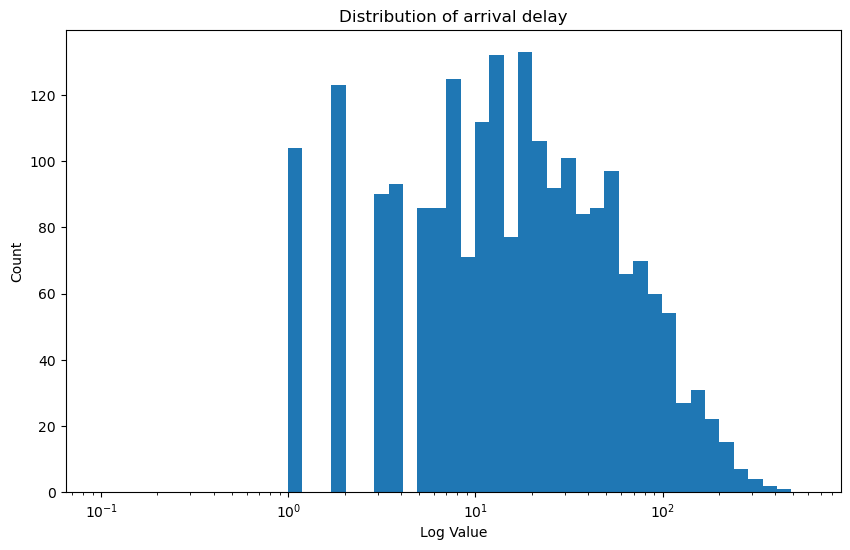

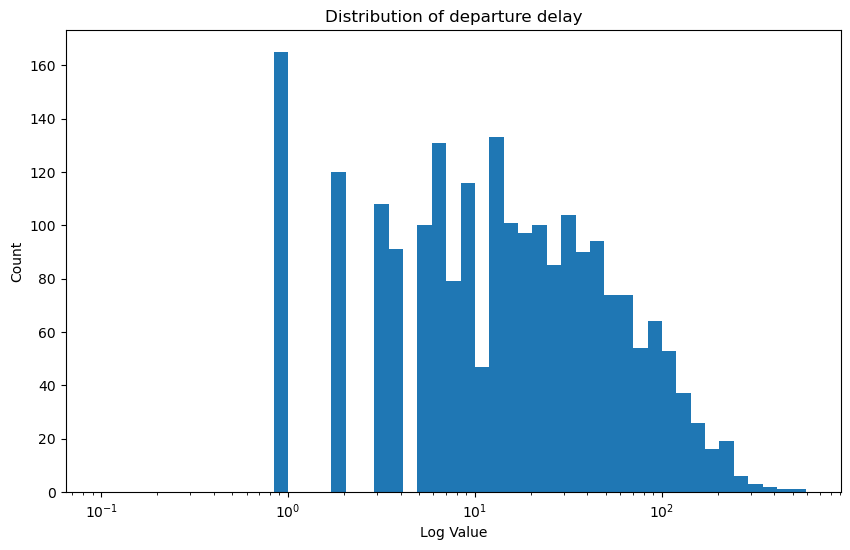

In [13]:
# Plot of the arrival_delay column
plot_histogram_of_column(flights["ARRIVAL_DELAY"], "Distribution of arrival delay", None, None, True, False)

# Histogram of DEPARTURE_DELAY column
plot_histogram_of_column(flights["DEPARTURE_DELAY"], "Distribution of departure delay", None, None, True, False)

It can be seen that both histograms share a similar shape, which means that these two variables are strongly correlated. However, we expected to get this result since those flights that suffer departure with any form of delay are extremely likely to also arrive with a similar delay.

Another interesting result extracted from the data is that there are quite a lot of flights that depart before their scheduled departure time. Moreover, if we compare closely both histograms, we will notice that the amount of flights that arrive before their arrival time is smaller than the number of flights that departure ahead of their departure time.

Next we are going to analyse how the variables containing data related with the date of the flight are distributed.

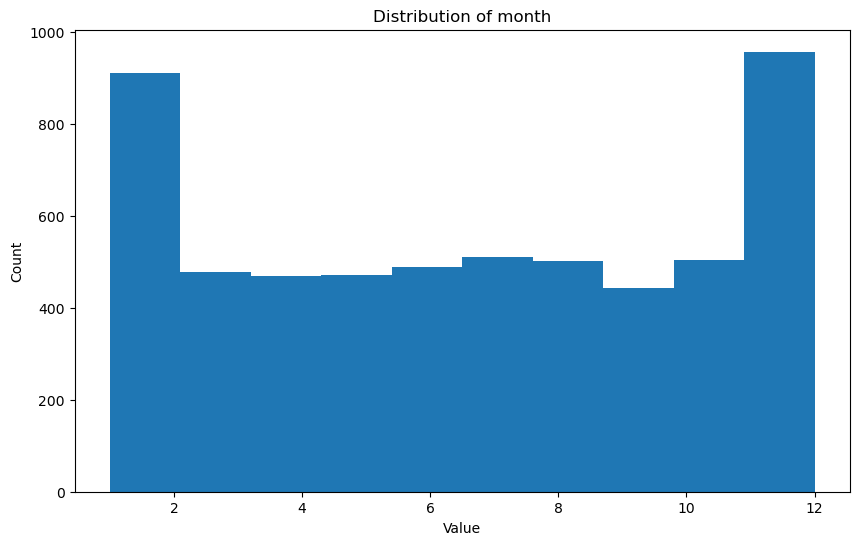

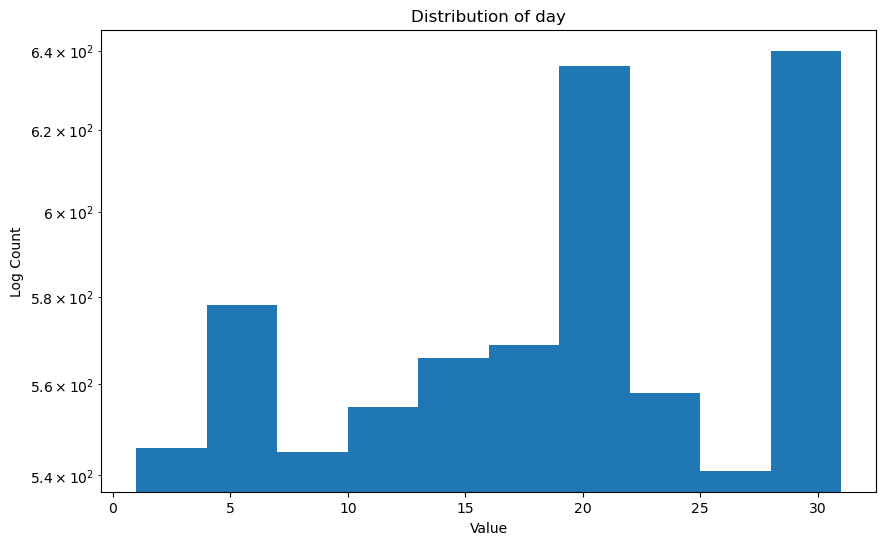

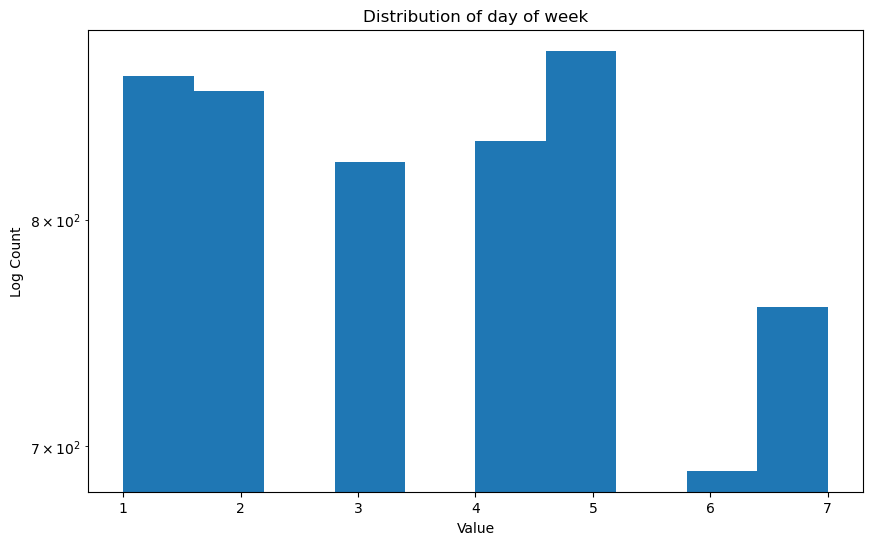

In [14]:
plot_histogram_of_column(flights["MONTH"], "Distribution of month", None, None, False, False)

# Create plot with histogram of DAY column
plot_histogram_of_column(flights["DAY"], "Distribution of day", None, None, False, True)

# Histogram of DAY_OF_WEEK colum
plot_histogram_of_column(flights["DAY_OF_WEEK"], "Distribution of day of week", None, None, False, True)



And, finally, we'll plot some other columns that could be interesting to analyse.

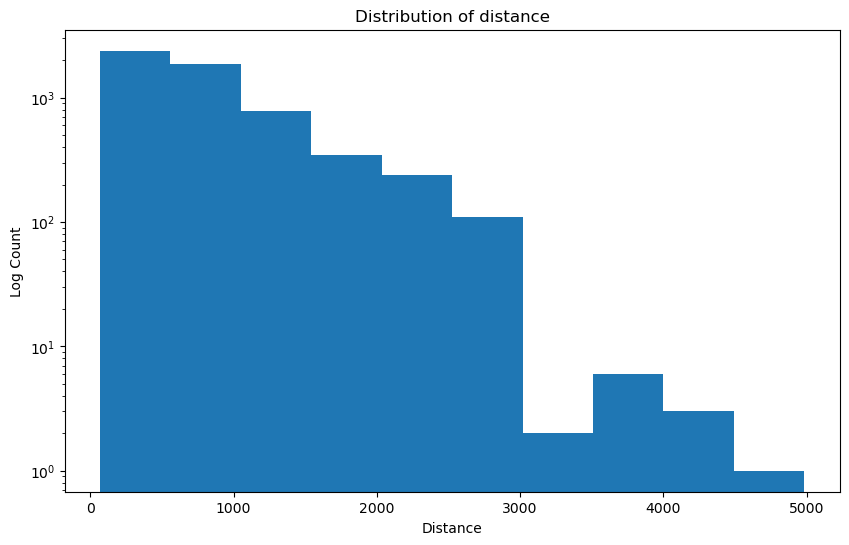

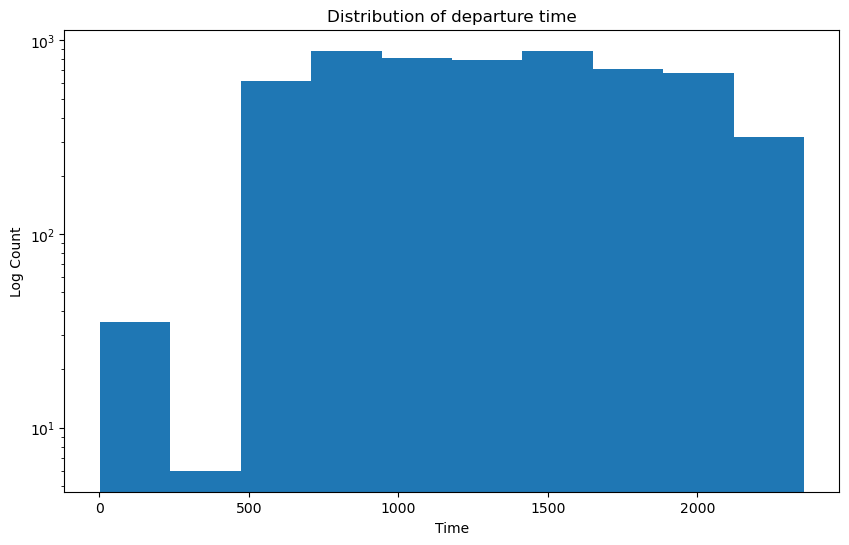

In [15]:
plot_histogram_of_column(flights["DISTANCE"], "Distribution of distance", "Distance", None, False, True)

plot_histogram_of_column(flights["DEPARTURE_TIME"], "Distribution of departure time", "Time", None, False, True)

Looking at the distance plot, we observe that the distance of the vast majority of flights range between a few hundred and a three thousand miles. The longest flights in the dataset are around 5000 miles. 

On the other hand, looking at the distribution of the departure time variabel, we see that fligh departure are almos uniformly distributed from 6 am to 8 pm. From 9 pm to 5 am, a much smaller number of departure take place.

In [16]:
print(flights["DESTINATION_AIRPORT"].unique())

['DTW' 'SEA' 'DAL' 'HNL' 'ATL' 'TPA' 'PHX' 'LAX' 11292 'BWI' 'SJU' 'SMF'
 'BNA' 'CLT' 'CAE' 'MSP' 'DFW' 'SAN' 'OGG' 'OAK' 14107 'DCA' 'BOS' 'HRL'
 'MCI' 'SNA' 'ORD' 'MIA' 'RNO' 12451 'SFO' 'SAT' 'IAH' 'SLC' 'LAS' 'DEN'
 'PIT' 'ACV' 'DRO' 'GSP' 'RSW' 'ITO' 12266 'LSE' 'OKC' 'DAY' 'EWR' 10299
 'PHL' 'HOU' 11298 'MFE' 'FLL' 'MSY' 'IND' 'BZN' 'PSP' 'ASE' 'MEM' 'RDU'
 'SBA' 15016 'SJC' 11066 'JAC' 'MCO' 'ROC' 11697 'BOI' 'CLE' 13830 10257
 14908 'SDF' 12278 'MKE' 'JFK' 12889 10397 'RDM' 13851 'BRW' 'ALB' 'OMA'
 'CRP' 'RIC' 'DHN' 11618 'BUR' 'CVG' 'MDW' 14893 'JAX' 13485 'ABQ' 12402
 'CMH' 12264 10721 'PVD' 11433 'KTN' 10154 'LGA' 'PDX' 'LRD' 'SYR' 'PBI'
 'ANC' 'BUF' 'RST' 'TUL' 'TUS' 'STL' 'TLH' 'BDL' 'AUS' 'MSN' 11278 13204
 14771 'CHS' '13232' 'DSM' '12478' 14869 'AMA' 'LGB' 'GRR' 'IAD' 10874
 'ONT' 'LIH' 'PIB' 15370 10980 13303 'GSO' 'MYR' 12478 11057 'BIS' 13930
 'CDV' 14679 10713 'MOB' 14576 'KOA' 'TRI' 'CHO' 14843 'LEX' 11447 'MGM'
 15919 14057 'ELP' 'IDA' 'MVY' 'EWN' 13487 10140 'COS

In [17]:
flights.loc[flights['WHEELS_OFF'] == 2400, 'WHEELS_OFF'] = 2359
flights.loc[flights['DEPARTURE_TIME'] == 2400, 'DEPARTURE_TIME'] = 2359



flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000
mean,4.989187,6.552843,15.775375,3.891350,1493.365364,1335.012208,9.553540,16.319672,1359.242588,142.360830,826.482386
std,36.408293,3.429423,8.714122,1.982626,506.631386,494.707026,33.884453,9.398211,495.475028,75.730927,613.115193
min,-58.000000,1.000000,1.000000,1.000000,2.000000,1.000000,-36.000000,4.000000,4.000000,30.000000,67.000000
25%,-13.000000,4.000000,8.000000,2.000000,1115.000000,925.000000,-5.000000,11.000000,941.000000,85.000000,371.000000
50%,-4.000000,7.000000,16.000000,4.000000,1519.000000,1328.000000,-1.500000,14.000000,1341.000000,123.000000,649.000000
75%,9.000000,10.000000,23.000000,6.000000,1914.000000,1740.000000,8.000000,19.000000,1754.000000,175.000000,1069.000000
max,581.000000,12.000000,31.000000,7.000000,2359.000000,2357.000000,588.000000,122.000000,2359.000000,575.000000,4983.000000


As we can infer from the output of the `decribe()` method, there are no values that are out of range or are non-sense in comparison with other values of the same column. 

In [18]:
# Delete all of the rows that contain integer values
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: isinstance(x, int))]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: isinstance(x, int))]


In [19]:
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: str(x).isnumeric())]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: str(x).isnumeric())]

### 1.4 Handle categorical data


We are going to start by looking at our columns to determine what type of data each one of them contains.


In [20]:
#Check nature of the columns 
for col in flights.columns:
  print(col, flights[col].dtype)

ARRIVAL_DELAY float64
MONTH int64
DAY int64
DAY_OF_WEEK int64
AIRLINE object
ORIGIN_AIRPORT object
DESTINATION_AIRPORT object
SCHEDULED_ARRIVAL int64
DEPARTURE_TIME float64
DEPARTURE_DELAY float64
TAXI_OUT float64
WHEELS_OFF float64
SCHEDULED_TIME float64
DISTANCE int64


Now that we have an idea of the nature of each column we must determine which columns we are going to modify. Those columns are going to be the ones containing categorical variables. We are going to modify:
- Month
- Arrival_delay
- Day
- Day_of_week
- Origin_airport
- Destination_airport

The next thing we want to do after observing the types of every feature is to transform some variables to categorical

#### Month column

The transformation we have chosen for the MONTH column is grouping the month by quarters. This will allow us to reduce the number of categories from 12 to 3. 

Additionally, when dividing the year in quarters we get a partition that closely matches the different travel seasons. Summer season matches almost perfectly with the second quarter while the first and third quarter match with winter season.

In [21]:
# MONTH treatment: group months in quarters
flights['Q_YEAR'] = flights['MONTH'].apply(lambda x: (x-1)//4 + 1)

#### Arrival_delay column

Another column which's data we need to process is the ARRIVAL_DELAY column. This column is the one we want to predict and the aim of our model is to be able to predict if a flight will arrive to its destination with some type of delay. Therefore, we want to convert this column into a column with binary values.

We will create a new column in our dataset (i.e. DELAYED) which will have a 1 if the flight is delayed and 0 otherwise.

In [22]:
# DELAY TREATMENT
flights['DELAYED'] = flights['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)

#### Day column

The DAY column has values that range from 1 to 31, which it's unfeasible to work with. We have decided to divide the month in two fortnights and classify each day with the value of the fortnight they belong to. 
- From days 1 - 15 they will belong to the first fortnight. They will have a value of 1.
- From days 15 - 31 they will belong to the second fortnight. The will have a value of 2.

In [23]:
# DAY treatment 

flights['FORTNIGHT'] = pd.cut(flights['DAY'], bins=[0, 15, 31], labels=[1, 2], include_lowest=True)


We believe that this is an appropiate transformation because, usually, people earn they salaries at the end of the month. Therefore, people will have more money available during the first fortnight and this could mean that the number of passengers increase causing to be more flights during the first fortnight. 


#### Day_of_week column

The same arguments we used for the DAY column apply to DAY_OF_WEEK. The values in this column range from 1 (i.e.: Monday) to 7 (i.e.: Sunday). Instead of working with each of this values, we are going to separate them into working days and weekends.

In [24]:
# DAY_OF_WEEK 1 is in-week days, 2 is weekend

flights['WEEK_INFO'] = pd.cut(flights['DAY_OF_WEEK'], bins=[1, 5, 7], labels=[1, 2], include_lowest=True)


#### Airline column

We are now going to treat the AIRLINES column. Originally, our dataframe had around 15 different airlines and we considered that it was going to be unfeasible to work with all of them. Therefore, we have decided to divide them intro three major groups:
- Major airlines
- Low cost airlines
- Regional airlines

We believe that this is a valid division because the nature of the airline could possibly affect the amount of delayed flights they have. 

In [25]:
# AIRLINE

# Define the airlines categories
major_airlines = ['DL', 'AA', 'UA', 'US', 'AS']
low_cost_airlines = ['WN', 'NK', 'F9', 'B6', 'VX']
regional_airlines = ['EV', 'OO', 'MQ', 'HA']

# create a new column with the airline category
flights['AC'] = 'Other'
flights.loc[flights['AIRLINE'].isin(major_airlines), 'AC'] = 'Major'
flights.loc[flights['AIRLINE'].isin(low_cost_airlines), 'AC'] = 'Low-Cost'
flights.loc[flights['AIRLINE'].isin(regional_airlines), 'AC'] = 'Regional'

#### Origin_airport column

In the original dataset there are over 300 different airports. Although it would be great to be able to keep all of them as individual categories, we have also considered it unfeasible. So, in order to reduce the number of categories, we are going to divide the USA territory in four quadrants:
- Upper left
- Upper right
- Bottom right
- Bottom left

However, before being able to classify the airports as we just mentioned, we first need to get its coordinates. This can be achieved by extracting the necessary data (i.e. longitude and latitude) from the *airports* dataset

In [26]:
# Change the index of the dataset to the IATA_CODE (code that identifies each airport)
airports = airports.set_index('IATA_CODE')

In [27]:
# Add LONGITUDE_O column to each row in flights with the longitude of the origin airport
flights['LONGITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])

# Add LATITUDE_O column to each row in flights with the latitude of the origin airport
flights['LATITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])

However, we have detected that some rows have a *NaN* value in either their longitude or latitude. Since this happens rarely, we can delete those columns without loosing to many rows. 

In [28]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_O"].isna() == False
count_false = sum(counter)
print(count_false/len(flights["LONGITUDE_O"]))
flights = flights.dropna(how='any')


0.9986618237430701


Once we have removed al conflictive rows, we can proceed with the classification of the airports by its location.

In [29]:
# Create empty column with airport location (i.e.: GR_O)
flights['GR_O'] = ''

# Classify the airports
# Upper right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_RIGHT'

# Upper left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_LEFT'

# Bottom right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_RIGHT'

# Bottom left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_LEFT'


Lastly, we check that all airports have been given a location and that there are no empty quadrants, which would indicate that the classification is not correctly implemented.

In [30]:
flights["GR_O"].unique()

array(['UPPER_RIGHT', 'BOTTOM_LEFT', 'UPPER_LEFT', 'BOTTOM_RIGHT'],
      dtype=object)

#### Destination_airport column

We are going to apply the same transformations we just applied for the destination airport column. We first add the coordinates of the airports.

In [31]:
flights['LONGITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])
flights['LATITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])



We remove all rows with NaN values.

In [32]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_D"].isna() == False
count_false = sum(counter)
print(count_false)
print(len(flights["LONGITUDE_D"]))

flights = flights.dropna(how='any')

5220
5224


And classify the destination airports based on their coordinates.

In [33]:
flights['GR_D'] = ''
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_LEFT'
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_LEFT'

In [34]:
flights["GR_D"].unique()

array(['UPPER_RIGHT', 'UPPER_LEFT', 'BOTTOM_RIGHT', 'BOTTOM_LEFT'],
      dtype=object)

#### Classify scheduled_time and departure_time

The original dataset has a few columns with values ranging from 0000 to 2359. This values are found in columns scheduled_time and departure_time and they represent an hour and minutes. The format is hhmm (i.e.: 1915 is 19:15).

Once again, having 2359 categories is unfeasible. The solution we have come up with is dividing the day between daytime and nightime.

In [35]:

# Define a function to classify the time segment based on the input time
def classify_time(time):
    sunrise = 600.0   # Define the time of sunrise as 6:00 am (in decimal format)
    sunset = 1800.0   # Define the time of sunset as 6:00 pm (in decimal format)
    
    if time >= sunrise and time < sunset:
        return 'Daytime'
    else:
        return 'Nighttime'
    

After having defined the function that will allow us to apply the classification, we apply it to the data.


In [36]:
# Change formatting of SCHEDULED_ARRIVAL and DEPARTURE_TIME
flights['ArrivalDayNight'] = flights['SCHEDULED_ARRIVAL'].apply(classify_time)
flights['DepartureDayNight'] = flights['DEPARTURE_TIME'].apply(classify_time)

#### Remove unwanted columns

After dealing with and processing all categorical data, we are left with a few unwanted columns, those ones we have used to create new columns. We will remove them.

In [37]:
flights.columns

Index(['ARRIVAL_DELAY', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR', 'DELAYED', 'FORTNIGHT',
       'WEEK_INFO', 'AC', 'LONGITUDE_O', 'LATITUDE_O', 'GR_O', 'LONGITUDE_D',
       'LATITUDE_D', 'GR_D', 'ArrivalDayNight', 'DepartureDayNight'],
      dtype='object')

In [38]:
flights = flights[['DELAYED','DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight']]

In [39]:
print(list(flights.columns))

['DELAYED', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O', 'GR_D', 'ArrivalDayNight', 'DepartureDayNight']


## Data visualization

### IMPORTANT
In order to do the process correctly, normalization across instances should be done after splitting the data between training and test set, using only the data from the training set. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance. In our case, that is what we are going to do right now.

In [40]:
from sklearn.model_selection import train_test_split

# Define X as the features (input variables)
X = flights.drop("DELAYED", axis=1)  # Replace "target_variable_column" with the actual name of the target column

# Define y as the target variable
y = flights["DELAYED"]  # Replace "target_variable_column" with the actual name of the target column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>,
        <AxesSubplot: title={'center': 'Q_YEAR'}>]], dtype=object)

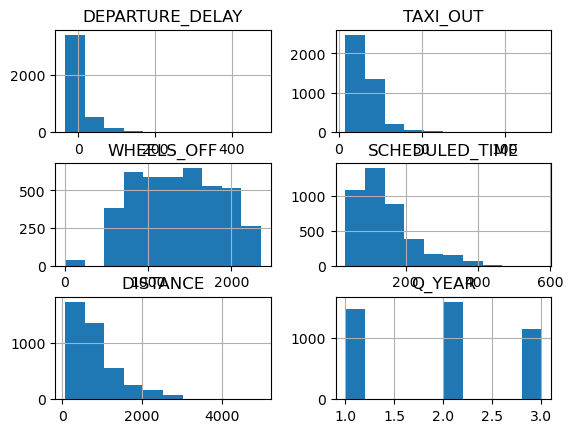

In [41]:
X_train.hist()

And we observe that the distribution of the features are the same than that of the whole dataset. 

Once we have processed all our data, it migh be interesting to, once again, visualize the distribution from some of the new columns we have added to the dataset and study if we can extract any knowledge from them.

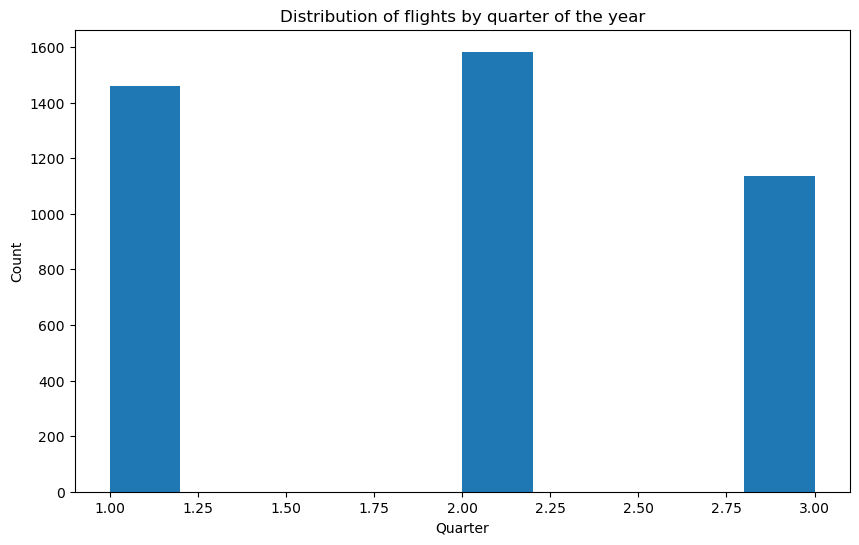

In [42]:
plot_histogram_of_column(X_train["Q_YEAR"], "Distribution of flights by quarter of the year", "Quarter", None, False, False)

While the difference between the three quarters it is not huge, it is clear that, as we expected, the second quarter (i.e.: May to August) is the one with the greater amount of flights as it matches with the summer season.

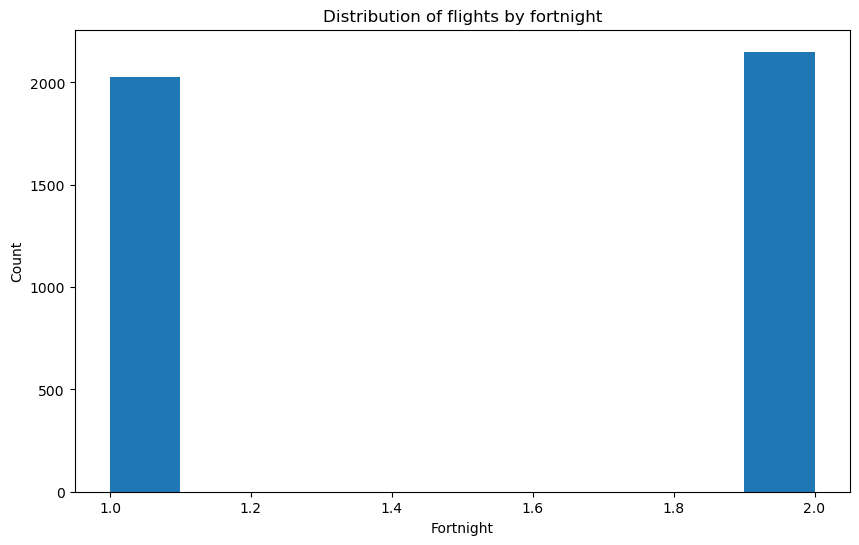

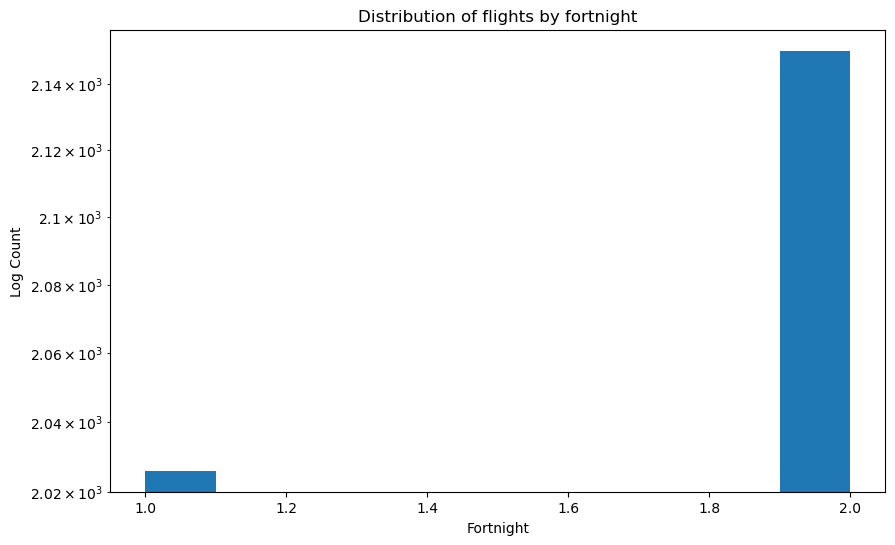

In [43]:
plot_histogram_of_column(X_train["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, False)
plot_histogram_of_column(X_train["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, True)

In this case, the difference is minimal. However, if we apply the logarithm to the y axis we can see that the second forntingh accumulates more flights than the first one.

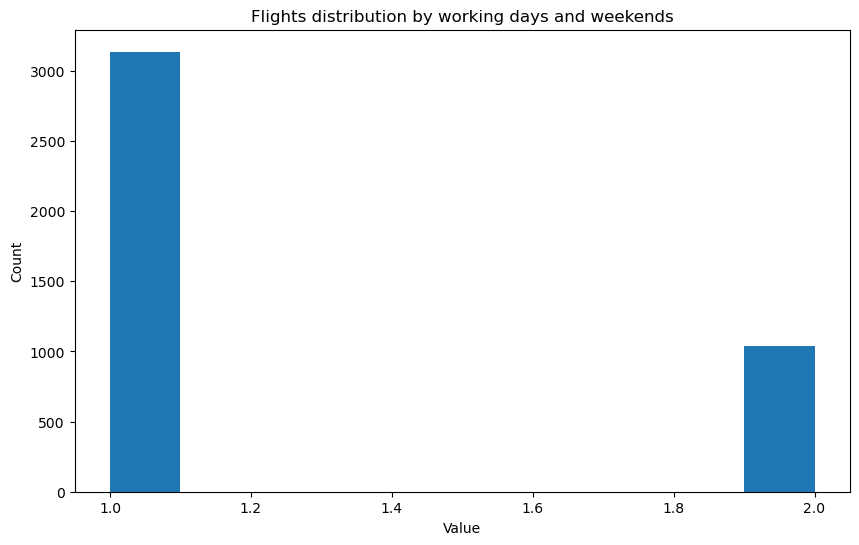

In [44]:
plot_histogram_of_column(X_train["WEEK_INFO"], "Flights distribution by working days and weekends", None, None, False, False)

As it could be expected, weekdays accumulate almost three times more flights than weekends. However, we must keep in mind that the weekday category groups five days while the weekend only groups two days. Probably, the difference wouldn't be this big if we were plotting the average number of flights per day. However, this escapes from the scope of this project as it doesn't provide any additional information that could be helpful to predict flight delays.

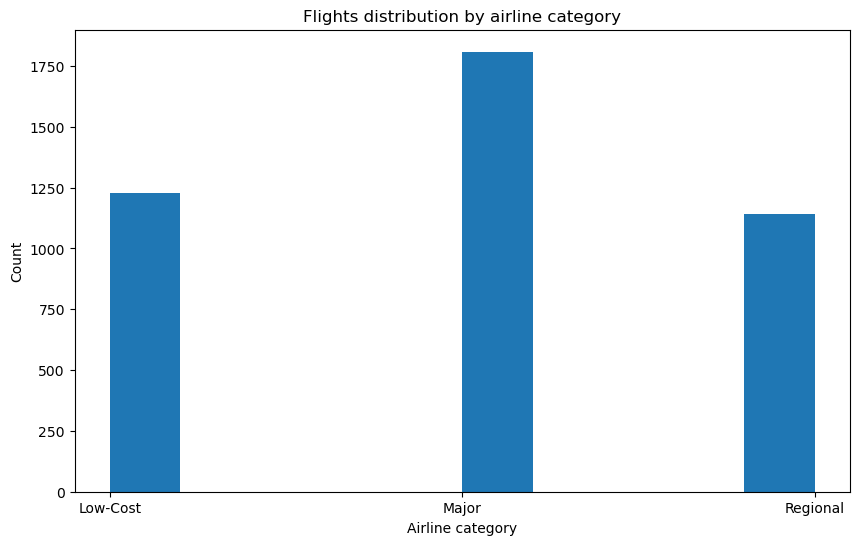

In [45]:
plot_histogram_of_column(X_train["AC"], "Flights distribution by airline category", "Airline category", None, False, False)

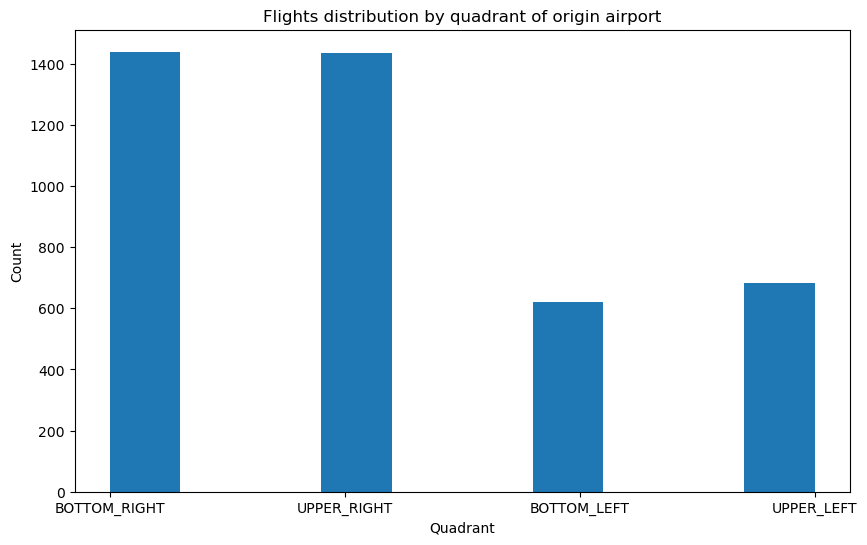

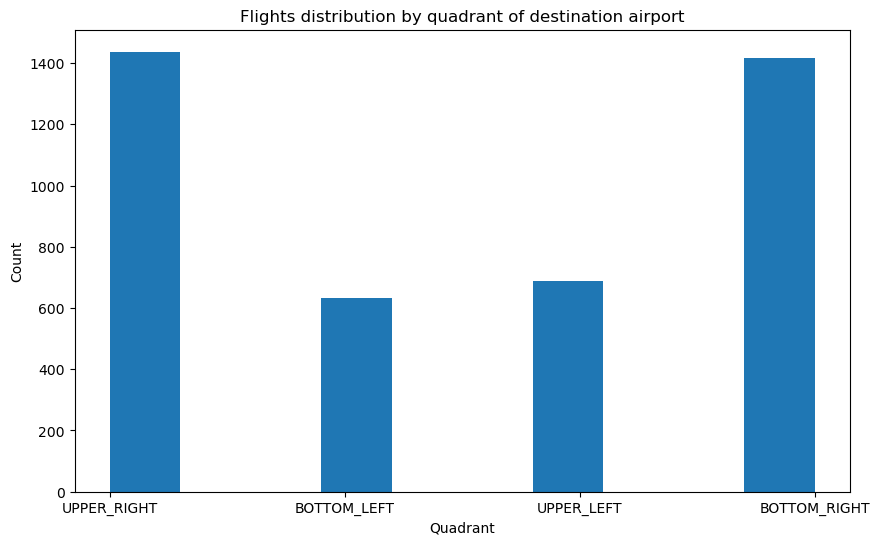

In [46]:
plot_histogram_of_column(X_train["GR_O"], "Flights distribution by quadrant of origin airport", "Quadrant", None, False,False)

plot_histogram_of_column(X_train["GR_D"], "Flights distribution by quadrant of destination airport", "Quadrant", None, False,False)

In both cases, the quadrants with the greater amount of flights are *UPPER_RIGHT* and *BOTTOM_RIGT*. This represents the east cost of the USA, where many of the biggest cities are located.

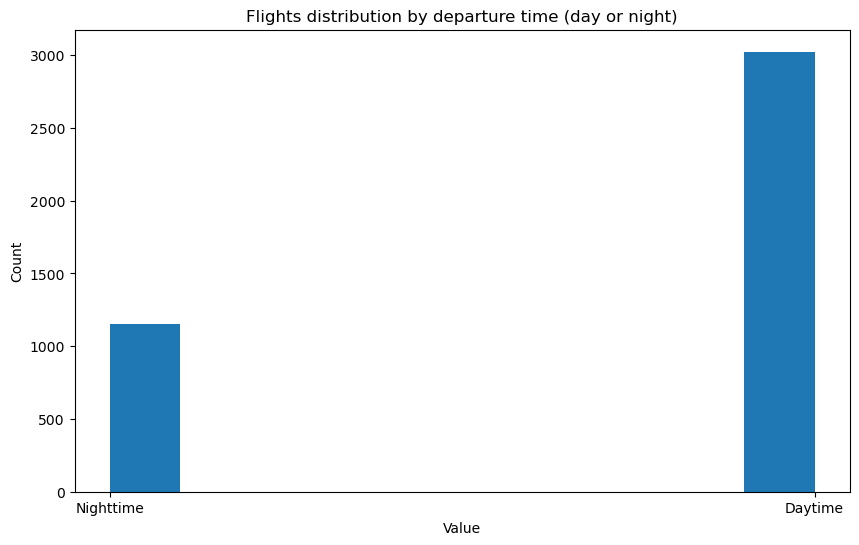

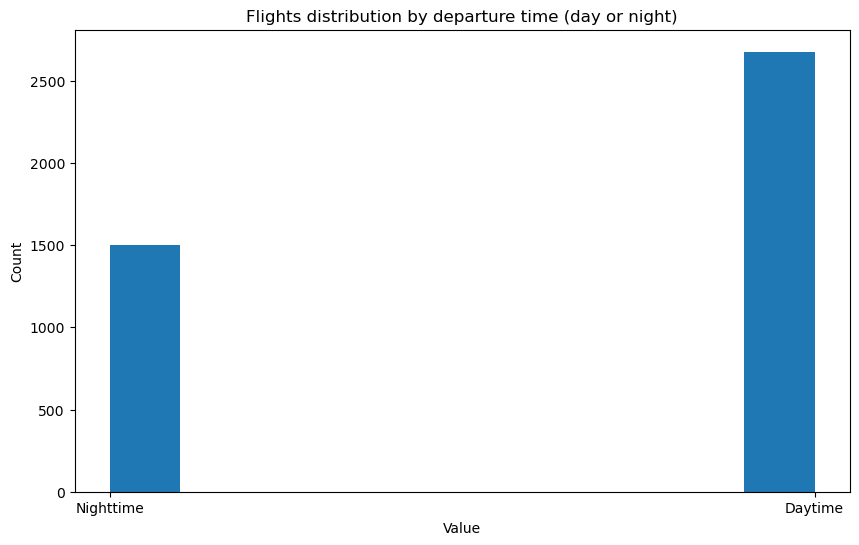

In [47]:
plot_histogram_of_column(X_train["DepartureDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

plot_histogram_of_column(X_train["ArrivalDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

Logically, most of the flights departure during daytime and this trend seems to hold for the arrival time. However, if we compare both histograms we will see that the amount of flights departing during daytime is considerably greater than the flights arriving during daytime. This mean that a considerable amount of flights arrive at their destination at night time even though day departed at daytime.

## Gausianization of continuous variables

Since the models we will apply assume that our data is distributed following a gaussian distribution, we need to make sure that our data is gaussian.

First of all, we are going to determine which columns of our dataset are the ones containing continuous data

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>, <AxesSubplot: >]],
      dtype=object)

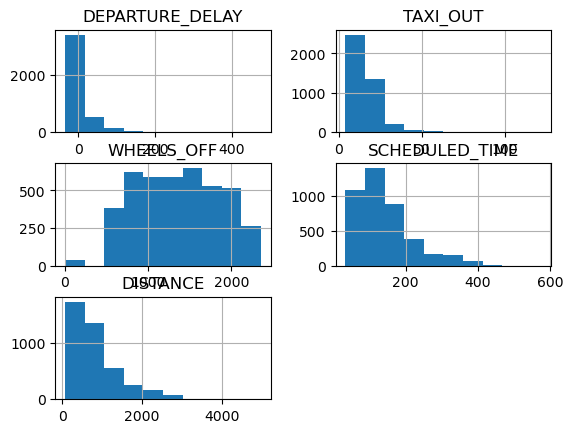

In [48]:
# Declare which variables are categorical and which ones are continuous. 

continuous = ['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE']

X_train[continuous].hist()               

We see that our data doesn't follow a gaussian distribution. Before gaussianizing it, we will first remove any outliers that can be identified in the dataset.

In [51]:

def remove_outliers_zscore(data_series, threshold=3):
    """
    Remove outliers from a pandas Series using the Z-score method.
    :param data_series: a pandas Series containing the data
    :param threshold: the number of standard deviations from the mean at which to consider a data point an outlier
    :return: a new pandas Series with the outliers removed
    """
    z_scores = np.abs((data_series - data_series.mean()) / data_series.std())
    return data_series[z_scores <= threshold]


In [56]:
# Remove outliers (no outliers in the whole dataset, no need to modify X_train and X_test)
flights_no_out = remove_outliers_zscore(flights[continuous])
print(len(flights), len(flights_no_out))

5220 5220


It can be seen that no outliers are removed. We can now proceed with the normalization of the continuous data defined before.

In [57]:
# we normalize continuous variables
from sklearn.preprocessing import QuantileTransformer

# Initialize transformer with number of quantiles and output distribution
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

# Apply transformation to continuous columns
for col in continuous:
    flights[col] = transformer.fit_transform(flights[col].values.reshape(-1, 1))
    X_train[col] = transformer.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = transformer.fit_transform(X_test[col].values.reshape(-1, 1))

And we plot the normalized data, which now clearly follow a gaussian distribution.

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>, <AxesSubplot: >]],
      dtype=object)

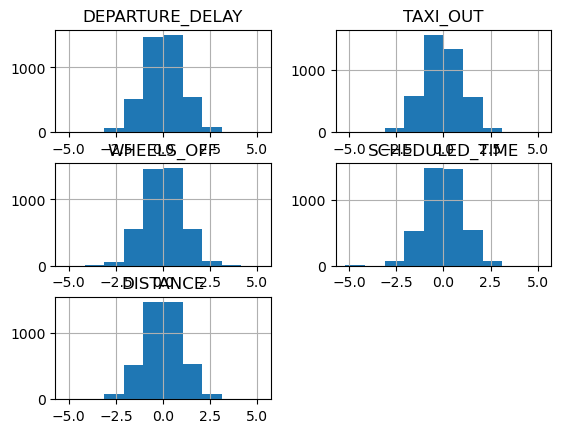

In [58]:
X_train[continuous].hist()

## One hot encoding of categorical variables

After dealing with the continuous variables, we will apply hot encoding to our categorical variables, which are:
- Q_year
- Fortnight
- Week_info
- Ac
- Gr_o
- Gr_d
- ArrivalDayNight
- DepartureDayNight

In [59]:
print(list(flights.columns))

['DELAYED', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O', 'GR_D', 'ArrivalDayNight', 'DepartureDayNight']


In [60]:
# one hot encoding for categorical variables
categorical = ['Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O','GR_D', 'ArrivalDayNight', 'DepartureDayNight']

flights= pd.get_dummies(flights, columns=categorical)
X_train = pd.get_dummies(X_train, columns = categorical)
X_test = pd.get_dummies(X_test, columns = categorical)

## Relations between pair of variables
From a pairplot diagram, we can infer several things:

- Correlation: The scatterplots in the pairplot diagram give us an idea of the relationship between variables. If the points in a scatterplot are closely clustered around a line or a curve, it suggests a strong correlation between those variables. 

- Distributions: The histograms on the diagonal of the pairplot diagram show the distribution of each variable individually. 

- Outliers: Outliers are data points that significantly deviate from the overall pattern in the scatterplots. 

Moreover, we believe is worth mentioning that we have included this graph just after normalizing our continuous variables since it improves drastically the colclusions that can be extracted from it because the pairplots obtained with the raw data where strongly influenced by some large values and it's analisis was quite difficult.

In [ ]:
pairplot_variables = ['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'DELAYED']

X_train['DELAYED'] = y_train

sns.pairplot(data=X_train[pairplot_variables][:1000], hue='DELAYED')

X_train = X_train.drop('DELAYED', axis=1)

The results of this plot will be commented in the final report.

### Feature selection (consider a subset of variables)
Nextly we will check if getting a smaller subset of variables we can get better results: 

In [62]:
# Initialize the feature selection model
feature_selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold='mean')

# Fit the feature selector on the training data
feature_selector.fit(X_train, y_train)

# Transform the training and test sets to include only the selected features
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

# Get the selected feature indices
selected_feature_indices = feature_selector.get_support(indices=True)

# Get the original feature names for the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE'],
      dtype='object')


Consider the two feature subsets during all the modelling

In [63]:
X_train_sf = X_train[selected_feature_names]
X_test_sf = X_test[selected_feature_names]

We firstly take a look at the difference in columns between both feature subsets:

In [64]:
X_train.columns

Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'Q_YEAR_1', 'Q_YEAR_2', 'Q_YEAR_3', 'FORTNIGHT_1',
       'FORTNIGHT_2', 'WEEK_INFO_1', 'WEEK_INFO_2', 'AC_Low-Cost', 'AC_Major',
       'AC_Regional', 'GR_O_BOTTOM_LEFT', 'GR_O_BOTTOM_RIGHT',
       'GR_O_UPPER_LEFT', 'GR_O_UPPER_RIGHT', 'GR_D_BOTTOM_LEFT',
       'GR_D_BOTTOM_RIGHT', 'GR_D_UPPER_LEFT', 'GR_D_UPPER_RIGHT',
       'ArrivalDayNight_Daytime', 'ArrivalDayNight_Nighttime',
       'DepartureDayNight_Daytime', 'DepartureDayNight_Nighttime'],
      dtype='object')

In [65]:
X_train_sf.columns

Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE'],
      dtype='object')

## Metric for choosing models

To start with, we are going to decide which of the metrics to use in order to compare our models and decide which of them is the best. We firstly observe the balance between classes

In [66]:
# Assuming your target variable is stored in a DataFrame or Series named "y"
class_counts = y.value_counts()
class_balance = class_counts / len(y) * 100

print("Class Balance:")
print(class_balance)


Class Balance:
0    61.570881
1    38.429119
Name: DELAYED, dtype: float64


With class 0 (i.e. on-time flights) at 62.41% and class 1 (i.e. delayed flights) at 37.59%, there is a noticeable difference in class frequencies, but it does not indicate severe class unbalance. However, it is still worth considering the implications of the unbalance and how it might affect our modeling approach.

When dealing with unbalanced data, it is important to be aware that standard evaluation metrics like accuracy may not provide an accurate representation of model performance. Instead, we need to focus on metrics that are more robust to class unbalance, such as precision, recall, F1 score, or area under the ROC curve (AUC-ROC).

Nevertheless, since the unbalance is not that big, we will also consider the accuracy score in order to choose our models. **We mainly will take into account the F1-score (taking into account then Recall and precision that will take into account the slightly unbalanced classes that we have) and the accuracy since we don't have that much unbalance**.


## Modeling 

To start with we quickly remind of some of the options we have to optimize the learning of our models and that we will (more or less) take into account when modelling. 

**Hyperparameter Tuning**: Fine-tune the hyperparameters of the model to find the optimal combination for our specific problem. We are going to use techniques like grid search, random search, or Bayesian optimization to systematically explore the hyperparameter space and identify the best configuration.

**Cross-Validation**: We will use cross-validation techniques, such as k-fold cross-validation, to evaluate our model's performance more reliably. This helps to assess how well our model generalizes to unseen data and reduces the risk of overfitting.

**Ensemble Methods**: Explore ensemble methods like bagging, boosting, or stacking to combine multiple models and improve overall performance. Ensemble techniques can help capture different patterns in the data and reduce model variance.

**Data Augmentation**: Since we have a lot of rows in our dataset, we will try with a small subset of this dataset and in the case this is not enough, we are going to proceed with picking a bigger subset of rows so that our model is able to sufficiently learn.

**Early Stopping**: Implement early stopping during model training to prevent overfitting and find the optimal number of training epochs. Early stopping stops training when the model's performance on a validation set starts to deteriorate.

**Model Architecture**: Experiment with different model architectures or network architectures, such as adding or removing layers, adjusting layer sizes, or trying different activation functions.

**Monitoring and Debugging**: Monitor your model during training, track performance metrics, and analyze learning curves to identify issues like underfitting, overfitting, or convergence problems. Debug any potential errors, explore misclassified samples, and consider adjusting your model or data accordingly.



In the following dataframe we are going to store the metrics for all of the models that we are going to fit in order to compare them. We are going to score metrics for every kind of model fitted with both subset of features and before and after HyperParameter tuning (HT). 

In [67]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

### Logistic Regression 

First we comment the hyperparameters we are going to tune: 

**C** :The C parameter in logistic regression controls the inverse of the regularization strength. It determines the trade-off between fitting the training data and preventing overfitting. Higher values of C result in less regularization, allowing the model to fit the training data more closely.

**penalty:** The penalty parameter specifies the type of regularization used in logistic regression.
'l1' penalty corresponds to L1 regularization. It adds a penalty term proportional to the absolute value of the coefficients, promoting sparsity by encouraging some coefficients to become exactly zero.

**solver:** The solver parameter determines the algorithm used to solve the optimization problem in logistic regression.
'saga' solver is an extension of the Stochastic Average Gradient (SAG) solver. It supports both L1 and L2 regularization and is suitable for large datasets.

We firstly fit the models for both subset of features: 

In [68]:
# Create a Logistic Regression model
logreg = LogisticRegression()

# Perform cross-validation using the Logistic Regression model
cv_results_logreg_1 = cross_validate(logreg, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression all features Before HT',:] = [cv_results_logreg_1['test_accuracy'].mean(), cv_results_logreg_1['test_f1_macro'].mean(),cv_results_logreg_1['test_precision_macro'].mean() , cv_results_logreg_1['test_recall_macro'].mean()]
results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression all features Before HT,0.825189,0.812466,0.819173,0.807884


In [69]:
# Create a Logistic Regression model
logreg = LogisticRegression()

# Perform cross-validation using the Logistic Regression model
cv_results_logreg_2 = cross_validate(logreg, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression subset features Before HT',:] = [cv_results_logreg_2['test_accuracy'].mean(), cv_results_logreg_2['test_f1_macro'].mean(),cv_results_logreg_2['test_precision_macro'].mean() , cv_results_logreg_2['test_recall_macro'].mean()]
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression all features Before HT,0.825189,0.812466,0.819173,0.807884
Logistic Regression subset features Before HT,0.824231,0.811369,0.81836,0.806757


Do hyperparameter tuning with the small subset of features: 

In [ ]:
# Create a Logistic Regression model
logreg = LogisticRegression()

# Define the hyperparameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

In [ ]:
# Create a Logistic Regression model with the best hyperparameters
logreg = LogisticRegression(C=1, penalty='l1', solver = 'saga')

cv_results_logreg_ht_1 = cross_validate(logreg, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression all features after HT',:] = [cv_results_logreg_ht_1['test_accuracy'].mean(), cv_results_logreg_ht_1['test_f1_macro'].mean(),cv_results_logreg_ht_1['test_precision_macro'].mean() , cv_results_logreg_ht_1['test_recall_macro'].mean()]
results_df


In [ ]:
# Create a Logistic Regression model with the best hyperparameters
logreg = LogisticRegression(C=1, penalty='l1', solver = 'saga')

cv_results_logreg_ht_2 = cross_validate(logreg, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression subset features after HT',:] = [cv_results_logreg_ht_2['test_accuracy'].mean(), cv_results_logreg_ht_2['test_f1_macro'].mean(),cv_results_logreg_ht_2['test_precision_macro'].mean() , cv_results_logreg_ht_2['test_recall_macro'].mean()]
results_df


We fit the best of the models that turns to be the logistic regression of all features after HT and observe the sparsity of the coefficients to consider possible modifications on the subset of features: 

In [ ]:
from sklearn.linear_model import LogisticRegression
# Fit the logistic regression model to your training data
logreg.fit(X_train, y_train)

X_train_copy = X_train

# Get the coefficients of the logistic regression model
coefficients = logreg.coef_[0]

# Create a mask indicating which coefficients are smaller than 0.01
mask = np.abs(coefficients) < 0.01

# Iterate until all coefficients are larger than 0.01
while np.sum(mask) > 0:
    # Get the indices of the features to be eliminated
    feature_indices_to_eliminate = np.where(mask)[0]

    # Eliminate the features from X_train
    X_train_copy = X_train_copy.drop(X_train_copy.columns[feature_indices_to_eliminate], axis=1)

    # Fit the logistic regression model to the updated training data
    logreg.fit(X_train_copy, y_train)

    # Get the updated coefficients
    coefficients = logreg.coef_[0]

    # Update the mask
    mask = np.abs(coefficients) < 0.01

# Print the final selected features
other_selected_features = X_train_copy.columns
print("Selected Features:", other_selected_features)

logreg.fit(X_train_copy, y_train)
f_coefficients = logreg.coef_
print(f_coefficients)

We now consider this third model using this new subset of features that we found in between and observe if it works out better. 


In [ ]:
# Create a Logistic Regression model
logreg = LogisticRegression()

# Define the hyperparameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_copy, y_train)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [ ]:
print(best_params)

In [ ]:
# Create a Logistic Regression model with the best hyperparameters
logreg = LogisticRegression(C=0.1, penalty='l2', solver = 'newton-cg')

cv_results_logreg_ht_2 = cross_validate(logreg, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression subset features after HT',:] = [cv_results_logreg_ht_2['test_accuracy'].mean(), cv_results_logreg_ht_2['test_f1_macro'].mean(),cv_results_logreg_ht_2['test_precision_macro'].mean() , cv_results_logreg_ht_2['test_recall_macro'].mean()]
results_df


Since we observe that this third subset of variables using the sparsity is not better, we will only consider it at the end with the final model. 

### Support Vector Machine (SVC)
First of all we recall the hyperparameters we are going to tune:

- **C:** Regularization parameter. It controls the trade-off between allowing training errors and maximizing the margin. Larger values of C penalize errors more, leading to a potentially narrower margin.

- **kernel:** Specifies the type of kernel function used for mapping the input data to a higher-dimensional feature space. Common options include linear, polynomial, radial basis function (RBF), and sigmoid.

- **gamma:** Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels. It defines the influence of training samples on the decision boundary.

We fit the SVC using the whole subset of features: 

In [ ]:
clf = SVC()
cross_val_results = pd.DataFrame(cross_validate(clf , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Now only using the best features: 

In [ ]:
clf = SVC()
cross_val_results = pd.DataFrame(cross_validate(clf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Since we have very similar results, let us compute the hyperparameter tuning with the SVC using only the small part of data. 

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.5, 1.0]
}

# Initialize the SVC model
clf = SVC()

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_sf, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


We now fit SVC using the hyperparameters that we found and using both datasets:

In [ ]:
clf = SVC(kernel='rbf', gamma = 'scale', C=1, coef0 = 0.0, degree = 2)
cross_val_results = pd.DataFrame(cross_validate(clf , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:
clf = SVC(kernel='rbf', gamma = 'scale', C=1)
cross_val_results = pd.DataFrame(cross_validate(clf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC subset features after HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

We are now observing that the subset of features is now doing better job than that of all the features surprisingly. The best combination is the last one we fitted.

### Naive Bayes
The parameters for a  GaussianNB are the following: 
- **Priors:** Prior probabilities of the classes. If specified, the priors are not adjusted according to the data. 
- **Var_smoothing:** Portion of the largest variance of all features that is added to variances for calculation stability.

However we are only going to tune var_smoothing. To proceed, we are going to fit the Naive Bayes model for both subsets of the features: 

In [ ]:
naive = GaussianNB()
cross_val_results = pd.DataFrame(cross_validate(naive , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:
naive = GaussianNB()
cross_val_results = pd.DataFrame(cross_validate(naive , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Since reducing features helps the model fit better we recall the other subset found from sparsity: 

In [ ]:
naive = GaussianNB()
cross_val_results = pd.DataFrame(cross_validate(naive , X_train_copy, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes subset 2 features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Since in this case it doesn not work any better we neglect this model. 

We now compute hyperparameter tuning using the smallest subset of features

In [ ]:
# Create a pipeline
pipeline = Pipeline([
    ('classifier', GaussianNB())
])

param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.25 ,0.3 , 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sf, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


We now fit the model using the best parameter we found: 

In [ ]:
naive = GaussianNB(var_smoothing = 1e-09)
cross_val_results = pd.DataFrame(cross_validate(naive , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:
naive = GaussianNB(var_smoothing = 1e-09)
cross_val_results = pd.DataFrame(cross_validate(naive , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In this case the best model is by far the one using the subset of features (the other one is probably overfitting) and in this case the hyperparamter tuning hasn't been helpful since the F1 score has decreased and the accuracy has almost remained the same. Therefore we belief that the best model is that of Gaussian Naive Bayes subset features After HT (or before). 

### LDA

Hyperparameters:

n_components: This hyperparameter specifies the number of components (dimensions) to retain after performing dimensionality reduction with LDA. By default, n_components is set to None, which means it will retain (n_classes - 1) components, where n_classes is the number of distinct classes in the data. In the param_grid, values of [None, 1, 2, 3] are provided to try different numbers of retained components. By setting n_components to a specific value, you can explicitly control the dimensionality of the reduced feature space.

shrinkage: Shrinkage is a regularization technique used to improve the estimation of the covariance matrix in LDA, especially when the number of samples is small or the covariance matrix is ill-conditioned. The shrinkage hyperparameter controls the degree of shrinkage applied. 
In the param_grid, the values [None, 'auto', 0.1, 0.5] are provided to try different levels of shrinkage:
None: No shrinkage is applied.
'auto': Shrinkage is estimated using the Ledoit-Wolf lemma, which automatically determines the amount of shrinkage based on the data.
0.1, 0.5: Specific values between 0 and 1 can be provided to manually set the shrinkage intensity.

solver: This hyperparameter specifies the solver used for LDA computation. LDA can be solved using different algorithms, and the solver parameter determines the specific algorithm to use. 
In the param_grid, the values ['svd', 'lsqr', 'eigen'] are provided to try different solver algorithms:
'svd': Singular Value Decomposition (SVD) solver, which computes the exact solution but can be slower for large datasets.
'lsqr': Least Squares solver, which can handle both shrinkage and regularized covariance matrix.
'eigen': Eigenvalue Decomposition solver, which computes the eigenvalues and eigenvectors of the covariance matrix.

We now fit the Linear Discriminant Analysis classifier for both subset of features: 

In [ ]:
lda = LinearDiscriminantAnalysis()
cross_val_results = pd.DataFrame(cross_validate(lda , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:
lda = LinearDiscriminantAnalysis()
cross_val_results = pd.DataFrame(cross_validate(lda , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

We now do hyperparameter tuning with the small subset of features dataset: 

In [ ]:
# Create an LDA classifier
lda = LinearDiscriminantAnalysis()

# Define the parameter grid
param_grid = {
    'n_components': [None, 1, 2, 3],    # Values to try for n_components
    'shrinkage': [None, 'auto', 0.1, 0.5],    # Values to try for shrinkage
    'solver': ['svd', 'lsqr', 'eigen'],    # Values to try for solver
    'tol': [1e-6,1e-5,1e-4, 1e-3, 1e-2]    # Values to try for tol
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

After hyperparameter tuning we fit the LDA with the hyperparameters we found: 

In [ ]:
lda = LinearDiscriminantAnalysis(n_components = None,shrinkage = None,  solver = 'lsqr', tol = 1e-06)
cross_val_results = pd.DataFrame(cross_validate(lda , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:
lda = LinearDiscriminantAnalysis()
cross_val_results = pd.DataFrame(cross_validate(lda , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

### Perceptron

We now fit the normal model for the perceptron. The hyperparameters are:

- **penalty:** Specifies the penalty term used in the update rule to handle misclassifications. It can be set to 'l1', 'l2', or 'elasticnet'. The default value is 'l2'.

- **alpha:** The constant that multiplies the penalty term if regularization is applied. It controls the strength of the regularization. The default value is 0.0001.

- **fit_intercept:** Indicates whether an intercept term should be included in the model. If set to True, the perceptron learns an intercept term. The default value is True.

- **max_iter:** The maximum number of passes over the training data (epochs) for training the perceptron. The default value is 1000.

- **tol:** The tolerance for the stopping criterion. It specifies the minimum change in the average loss for training to continue. The default value is 1e-3.

- **shuffle:** Determines whether to shuffle the training data before each epoch during training. The default value is True.

- **eta0:** The initial learning rate. It controls the step size at each update during training. The default value is 1.0.

- **early_stopping:** If set to True, training will stop when validation loss does not improve anymore. The default value is False.

- **validation_fraction:** The proportion of training data to use for early stopping validation. The default value is 0.1.

- **n_iter_no_change:** The maximum number of epochs to wait for the validation loss to improve when early_stopping is enabled. The default value is 5.

We now fit the models for both subsets of features: 

In [ ]:

perceptron = Perceptron()
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df


In [ ]:

perceptron = Perceptron()
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df


We now tune the hyper parameters using the smallest subset of features: 

In [ ]:

perceptron = Perceptron()

# Here we define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization penalty type
    'alpha': [0.0001, 0.001, 0.01],         # Regularization parameter
    'max_iter': [1000, 2000, 3000],         # Maximum number of iterations
    'eta0': [0.1, 0.01, 0.001],             # Initial learning rate
    'tol': [10,1,1e-1,1e-2,1e-3]            # Tolerance for stopping criterion
}

grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sf, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

We now fit with the found hyperparameters:

In [ ]:

perceptron = Perceptron(alpha = 0.01, eta0=0.1, max_iter=1000, penalty='l1', tol=0.001)

perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df


In [ ]:

perceptron = Perceptron(alpha = 0.01, eta0=0.1, max_iter=1000, penalty='l1', tol=0.001)

perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In this case we observe that the best model is by far the last we fitted: Perceptron subset features After HT, since it has the best accuracy and f1 score

### Gradient boost 

The hyperparameters for the gradient boost are:

- **n_estimators:** The number of boosting stages to perform.

- **learning_rate:** The learning rate or shrinkage parameter, which controls the contribution of each tree.

- **max_depth:** The maximum depth of individual trees in the ensemble.

- **subsample:** The subsample ratio of the training instances.

- **min_samples_split:** The minimum number of samples required to split an internal node.

We fit the model for both subset of features: 


In [ ]:

gb_classifier = GradientBoostingClassifier()
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:

gb_classifier = GradientBoostingClassifier()

cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:

gb_clf = GradientBoostingClassifier()

# We define the hyperparameter grid 
param_grid = {
    #'n_estimators': [50, 100, 200],  # Number of boosting stages to perform
    #'learning_rate': [0.1, 0.01, 0.001],  # Learning rate (shrinkage parameter)
    'max_depth': [3, 4, 5],  # Maximum depth of individual trees
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'min_samples_split': [2, 3, 4]  # Minimum number of samples required to split an internal node
}

grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_sf, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

We now tune the left hyperparameters: 

In [ ]:

gb_clf = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],  # Number of boosting stages to perform
    'learning_rate': [1,0.1, 0.01, 0.001],  # Learning rate (shrinkage parameter)
    'max_depth': [4],  # Maximum depth of individual trees
    'subsample': [0.8],  # Subsample ratio of the training instances
    'min_samples_split': [3]  # Minimum number of samples required to split an internal node
}

grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


In [ ]:

gb_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=50, subsample=0.8)
# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:
gb_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=50, subsample=0.8)
# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

We obtain slightly better results with the Gradient Boost subset features After HT. 

### Random forest
The hyperparameters we can tune for the random forest are:

- **n_estimators:** The number of decision trees in the random forest. Increasing the number of estimators typically improves performance but increases computational complexity. It represents the ensemble size.

- **max_depth:** The maximum depth of each decision tree in the forest. Higher values increase model complexity and can lead to overfitting.

- **min_samples_split:** The minimum number of samples required to split an internal node. Larger values prevent overfitting by requiring a certain number of samples in each split.

- **min_samples_leaf:** The minimum number of samples required to be at a leaf node. Similar to min_samples_split, larger values help control overfitting by requiring a minimum number of samples in each leaf.

- **max_features:** The number of features to consider when looking for the best split. Reducing this number can help control overfitting. Values such as 'sqrt' or 'log2' can be used to consider a square root or logarithm of the total features, respectively.

- **bootstrap:** Determines whether bootstrap samples are used when building trees. Setting it to True enables bootstrap sampling, while False disables it. Bootstrap sampling introduces randomness into the training process and helps improve model diversity.

- **criterion:** The function used to measure the quality of a split. For classification, 'gini' or 'entropy' are commonly used. For regression, 'mse' (mean squared error) or 'mae' (mean absolute error) can be used.

We have an additional parameter (not to tune) which is criterion: The function used to measure the quality of a split. For classification, 'gini' or 'entropy' are commonly used. For regression, 'mse' (mean squared error) or 'mae' (mean absolute error) can be used.

We first fit the normal model with both subset of features: 

In [ ]:

rf_classifier = RandomForestClassifier()
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:

rf_classifier = RandomForestClassifier()
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

We now proceed to do hyperparameter tuning with the small subset of features: 

In [ ]:

random_forest = RandomForestClassifier()

# We must first define the parameter grid
param_grid = {
    #'n_estimators': [100, 200, 500],
    #'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

And now we can use the results of the hyperparameter tunning to fit betters random forest for both of our datasets.

In [ ]:

rf_classifier = RandomForestClassifier(bootstrap = True, criterion='entropy', max_features='log2', min_samples_leaf=4, min_samples_split=15,random_state=42)
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

In [ ]:

rf_classifier = RandomForestClassifier(bootstrap = True, criterion='gini', max_depth=None, max_features='log2', min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=42)
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

### Neural Nets
Hyperparameters: 

- **Learning rate**: The learning rate determines how much the weights are updated in response to the estimated error each time the model weights are updated. Choosing the right learning rate can be crucial as a value too small may result in a long training process that could get stuck, while a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

- **Optimizer:** what type of optimizer you want to use

- **Batch size:** This is the number of samples to work through before updating the internal model parameters. A smaller batch size can lead to more updates and potentially faster convergence, but it also introduces more variance, which can lead to instability in the learning process.

- **Activation function:** Different activation functions can result in significant differences in the performance of a neural network. The Rectified Linear Unit (ReLU) and its variants (like Leaky ReLU, Parametric ReLU) are often a good starting point for many problems.

We now do some neural nets. 

In [ ]:
# install needed packages for following modeling
!pip install scikeras

#### Neural Network I 
Fit neural network with all the features: 

In [ ]:
input_dim = X_train.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=10, batch_size=32)

In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network I all features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]

Fit with the subset of variables: 

In [ ]:
input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=10, batch_size=32)

In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network I subset features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]



In [ ]:
results_df

In [ ]:
input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model(optimizer=Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)

# Define the hyperparameters and their respective values to tune
param_grid = {
    'batch_size': [32, 64, 96],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'], refit='f1_macro')

# Perform hyperparameter tuning
grid_search.fit(X_train_sf, y_train)

In [ ]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

#### Neural Network II
We firstly fit the neural network with both subsests of features.



With all the features: 

In [ ]:
input_dim = X_train.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=30, batch_size=32)

In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network II all features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


Fit the model with small subset of features

In [ ]:
input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=50, batch_size=64, optimizer=Adam(learning_rate=0.001))

In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network II subset features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network II all features after HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


In [ ]:
results_df

Since we cannot do hyperparameter tuning because of the vast quantity of time needed (no time left enough), we are going to reconsider the other subset of features obtained from the sparsity of logistic regression and evaluate it on both neural networks: 

In [ ]:
input_dim = X_train_copy.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=10, batch_size=32)

In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train_copy, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network I subset 2 features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]

In [ ]:
results_df

In [ ]:
input_dim = X_train_copy.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=30, batch_size=32)

In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train_copy, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network II subset 2 features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


In [ ]:
results_df

## Conclusions

Once we have tried and tested all the previous classifiers, we are going to select the one with the best overall performance.

In [ ]:
# Sort the DataFrame by the 'F1 Macro' column in descending order
sorted_df = results_df.sort_values(by='F1 Macro', ascending=False)

sorted_df


As we can see, the best results are obtained using the first neural network.

In [ ]:
input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=10, batch_size=32)

In [ ]:
# Fit the model to the training data
keras_classifier.fit(X_train_sf, y_train)

# Predict using the trained model on the test data
y_pred = keras_classifier.predict(X_test[selected_feature_names])


In [ ]:
# Obtain the predicted probabilities from the model
y_pred_prob = keras_classifier.predict_proba(X_test[selected_feature_names])

# Set the decision threshold to 0.45
threshold = 0.45

# Apply the threshold to the predicted probabilities
y_pred = (y_pred_prob[:, 1] >= threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


For the final classifier, we can compute the confusion matrix in order to analyse more in depth how is our model performing. This results are commented in the report.

In [ ]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [ ]:
confusion(y_test, pd.Series(y_pred))